## Chargement des données

Importation des librairies utilisées dans le calepin.

// TODO: à enlever à la fin:

Pour importer librairies:
using Pkg
Pkg.add(["CSV", "DataFrames", "Combinatorics", "Gadfly", "Distributions"], ...)

In [1077]:
#= import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("DecisionTree") =#

In [1078]:
using CSV, DataFrames, Statistics, Dates, Gadfly, LinearAlgebra, DecisionTree,Random, Plots

In [1079]:
trainData = CSV.read("../../data/train.csv", DataFrame)
testData = CSV.read("../../data/test.csv", DataFrame)
trainData.consommation = parse.(Float64,replace.(trainData.consommation, "," => "."))
trainData.cylindree = parse.(Float64,replace.(trainData.cylindree, "," => "."))
testData.cylindree = parse.(Float64,replace.(testData.cylindree, "," => "."))


COMSOMMATION_MEAN = mean(trainData.consommation)
COMSOMMATION_STD = std(trainData.consommation)
trainData[!, :id] = 1:nrow(trainData)
testData[!, :id] = 1:nrow(testData)


1:150

In [1080]:
function format_file(predictions,i)
    file_name = "benchmark_$i.csv"
    CSV.write("./" *file_name, predictions)
end

format_file (generic function with 1 method)

In [1081]:
function get_unique_data(data, columns_to_compare)
    unique_data = combine(groupby(data, columns_to_compare), :consommation => mean)
    rename!(unique_data, :consommation_mean => :consommation)
   return unique_data
end

function find_pairs(data_train, data_predict, columns_to_compare)
    train_data_without_consommation = select(data_train, Not(:consommation))
    predict_data_without_annee = select(data_predict, Not(:annee))
    common_values = innerjoin(data_train, data_predict, on=columns_to_compare)
    return common_values
end
    

find_pairs (generic function with 1 method)

In [1082]:
function forest_regression(training_data, test_data)
    ids = test_data.id

    y_train = training_data.consommation
    common_columns = intersect(names(training_data), names(test_data))
    training_data = training_data[:, common_columns]
    test_data = test_data[:, common_columns]

    X_train = Matrix(training_data[:, Not(:annee, :id)])
    X_test = Matrix(test_data[:, Not(:annee, :id)])

    model = RandomForestRegressor(n_subfeatures=5, n_trees=1000,min_samples_leaf=1,min_purity_increase=0.0, max_depth=5, min_samples_split=6)
    fit!(model, X_train, y_train)
    ychap =  predict(model, X_test)  

    prediction = DataFrame(id=ids, consommation=ychap)

    return prediction    
end

forest_regression (generic function with 1 method)

In [1083]:
COLUMNS_TO_COMPARE_1 = ["type", "nombre_cylindres", "cylindree", "transmission", "boite"]
COLUMNS_TO_COMPARE_2 = ["nombre_cylindres", "cylindree", "type" ]
COLUMNS_TO_COMPARE_3 = ["nombre_cylindres", "cylindree"]

trainData.type = ifelse.(trainData.type .== "break_petit", "break_moyen", trainData.type)
testData.type = ifelse.(testData.type .== "break_moyen", "break", testData.type)

testData.type = ifelse.(testData.type .== "camionnette_standard", "cam", testData.type)

trainData = filter(row -> row.type != "monospace", trainData)
trainData.type = ifelse.(trainData.type .== "voiture_deux_places" .&& trainData.nombre_cylindres .>= 8 .&& trainData.boite .== "manuelle" .&& trainData.transmission .== "integrale", "voiture_sport", trainData.type)
testData.type = ifelse.(testData.type .== "voiture_deux_places" .&& testData.nombre_cylindres .>= 8 .&& testData.boite .== "manuelle" .&& testData.transmission .== "integrale", "voiture_sport", testData.type)

function match_predictions(train_data, data_to_predict, pairs, columns_to_compare)
    unique_data = get_unique_data(train_data, columns_to_compare)
    new_pairs = find_pairs(unique_data, data_to_predict, columns_to_compare)
    new_pairs = select(new_pairs, [:id, :consommation])
    pairs = vcat(pairs, new_pairs)
    data_to_predict = filter(row -> !(row.id in pairs.id), data_to_predict)
    return pairs, data_to_predict
end

function main(trainData, testData)
    pairs = DataFrame(id=Int[], consommation=Float64[])
    pairs, testData = match_predictions(trainData, testData, pairs, COLUMNS_TO_COMPARE_1)

    data_to_predict_by_forest = deepcopy(testData)
    perfect_match_pairs = deepcopy(pairs)

    
    pairs, testData = match_predictions(trainData, testData, pairs, COLUMNS_TO_COMPARE_2)
    pairs, testData = match_predictions(trainData, testData, pairs, COLUMNS_TO_COMPARE_3)

    ids_with_no_match = testData.id


    forest_predictions = forest_regression(trainData, data_to_predict_by_forest)

    no_match_predictions = forest_predictions[forest_predictions.id .== ids_with_no_match, :]

    matching_predictions = vcat(pairs, no_match_predictions)
    sort!(matching_predictions, :id)

    forest_predictions = vcat(perfect_match_pairs, forest_predictions)
    sort!(forest_predictions, :id)

    average_predictions = (matching_predictions.consommation .+ forest_predictions.consommation) ./ 2

    average_predictions = DataFrame(id=1:150, consommation=average_predictions)

    println(average_predictions[5,:])


    return average_predictions

end
average_predictions = main(trainData, testData)


DataFrameRow
 Row │ id     consommation 
     │ Int64  Float64      
─────┼─────────────────────
   5 │     5       13.8885


Row,id,consommation
,Int64,Float64
1,1,8.11069
2,2,7.59532
3,3,8.66848
4,4,8.71148
5,5,13.8885
6,6,13.8359
7,7,13.8359
8,8,10.2265
9,9,10.9459


In [ ]:
data_17 = CSV.read("./benchmark18_equipe_T.csv", DataFrame)
# data_tree = CSV.read("./benchmark_2.csv", DataFrame)
# data_out = CSV.read("./benchmark_1.csv", DataFrame)

sort(data_17, :id)

difference = average_predictions.consommation - data_17.consommation

diff_df = DataFrame(id=average_data.id, diff=difference)

total_diff = sum(abs.(diff_df.diff).^2)/150

println(total_diff)


2.254169531500399e-5
0×2 DataFrame
 Row │ id     diff    
     │ Int64  Float64 
─────┴────────────────


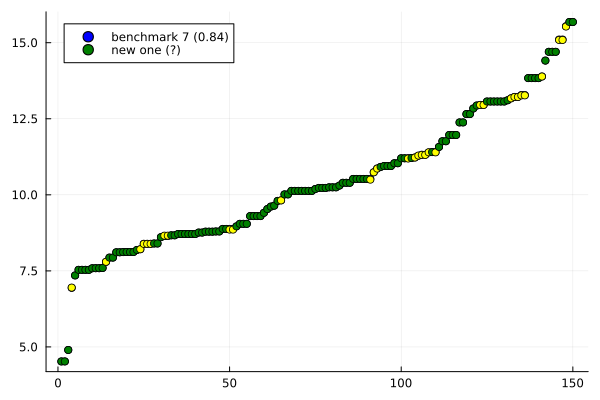

In [1085]:
common_ids = intersect(data_17.id, average_predictions.id)
diff_ids = filter(id -> data_17[data_17.id .== id, :consommation] != average_predictions[average_predictions.id .== id, :consommation], common_ids)
data_1_common = filter(row -> row.id in common_ids, data_17)
data_2_common = filter(row -> row.id in common_ids, average_predictions)


data_1_sorted = sort(data_17, :consommation)
data_2_sorted = [average_predictions.consommation[i] for i in data_1_sorted.id]
#= data_3_sorted = [data_3.consommation[i] for i in data_1_sorted.id]
 =#
colors1 = [(i in common_ids ? :blue : :blue) for i in data_1_sorted.id]
colors2 = [(i in diff_ids ? :yellow : :green) for i in data_1_sorted.id]
#= colors3 = [(i in common_ids ? :black : :white) for i in data_1_sorted.id]
 =#

scatter(1:150, data_1_sorted.consommation, c=colors1, label="benchmark 7 (0.84)")
scatter!(1:150, data_2_sorted, c=colors2, label= "new one (?)")